## Mitsuba "Plugin 1"

Stufying the logic of the Mitsuba plugin machinery.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.6349573].


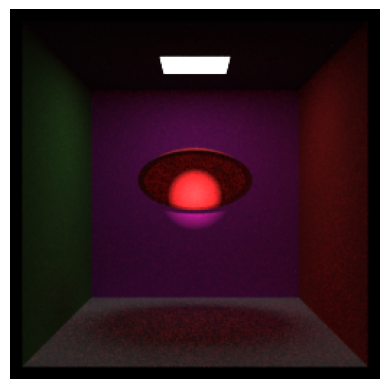

In [2]:
#!/usr/bin/env python3
import matplotlib.pyplot    as plt
import mitsuba              as mi
mi.set_variant("llvm_ad_rgb")
from mitsuba import *

import drjit as dr

# ---
class MyBSDF(mi.BSDF):
    def __init__(self, props):
        mi.BSDF.__init__(self, props)
        self.m_reflectance \
            = mi.load_string('''<spectrum version='2.0.0' type='srgb' name="reflectance">
                                <rgb name="color" value="0.99, 0.10, 0.10"/>
                             </spectrum>''')
        self.m_flags = BSDFFlags.DiffuseReflection | BSDFFlags.FrontSide
        self.m_components = [self.m_flags]

    def sample(self, ctx, si, sample1, sample2, active):
        cos_theta_i = Frame3f.cos_theta(si.wi)

        active &= cos_theta_i > 0

        bs = BSDFSample3f()
        bs.wo  = warp.square_to_cosine_hemisphere(sample2)
        bs.pdf = warp.square_to_cosine_hemisphere_pdf(bs.wo)
        bs.eta = 1.0
        bs.sampled_type = +BSDFFlags.DiffuseReflection
        bs.sampled_component = 0

        value = self.m_reflectance.eval(si, active)

        return ( bs, dr.select(active & (bs.pdf > 0.0), value, Vector3f(0)) )

    def eval(self, ctx, si, wo, active):
        if not ctx.is_enabled(BSDFFlags.DiffuseReflection):
            return Vector3f(0)

        cos_theta_i = Frame3f.cos_theta(si.wi)
        cos_theta_o = Frame3f.cos_theta(wo)

        value = self.m_reflectance.eval(si, active) * (1/3.1415926) * cos_theta_o

        return dr.select((cos_theta_i > 0.0) & (cos_theta_o > 0.0), value, Vector3f(0))

    def pdf(self, ctx, si, wo, active):
        if not ctx.is_enabled(BSDFFlags.DiffuseReflection):
            return Vector3f(0)

        cos_theta_i = Frame3f.cos_theta(si.wi)
        cos_theta_o = Frame3f.cos_theta(wo)

        pdf = warp.square_to_cosine_hemisphere_pdf(wo)

        return dr.select((cos_theta_i > 0.0) & (cos_theta_o > 0.0), pdf, 0.0)

    def to_string(self):
        return "MyDiffuseBSDF[reflectance = %s]".format(self.m_reflectance.to_string())
    
# ---------------------------------------------------

mi.register_bsdf("mybsdf", lambda props: MyBSDF(props))
scene   = mi.load_file("../scenes/pluginbox.xml")
img1    = mi.render(scene, spp=128)
plt.axis("off")
plt.imshow(img1 ** (1.0 / 1.7))
